# Performing linear regression with maximum likelihood estimation

Using the agent to infer linear generating function parameters instead of hidden states.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 3 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

from scipy.stats import norm, uniform
from types import SimpleNamespace

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_environment

mpl.style.use("seaborn-deep")

In Chapter 2, we explored the concept of hidden state estimation, also known as **state inference**. This process entailed determining the value of an unobserved $x$, from an observed value of $y$, where $y$ could be a single sample or multiple samples. We made the assumption that our parameters of interest, the linear parameters $\theta = \left \{\beta_0, \beta_1 \right \}$ and other parameters $\phi = \left \{\sigma^2_y, s^2_x, m_x \right \}$ were already learned, perhaps from the agent's previous encounters with food size in the environment. Perhaps we could say that in the agent's environmental niche, the food it typically encounters generally follows the linear relationship captured by the $\beta_0$ and $\beta_1$. Now suppose that the agent is in a new environment where this linear relationship has changed. It could use its past knowledge about the relationship between $x$ and $y$ to help it adjust (learn) new model parameter settings that are appropriate for the new environment so it can make better hidden state inferences. Note that what this means is that during the learning step, we can use our knowledge (or expectation) of $x$ along with $y$ to better inform us about how to adjust the model parameters.

Thus, in this notebook, our aim is to demonstrate the process of **parameter estimation**, which is the learning step. Then we can see how this learning step can inform the inference step. In this notebook, we will assume that the only parameters that the agent wishes to update are $\beta_0$ and $\beta_1$, the linear parameters. We are interested in just deterministic updates for these parameters, i.e., these parameters are not random variables. Therefore, this is a good application of maximum likelihood estimation (MLE) which we encountered at the end of Chapter 2. 

We will be performing a rather unusual take on linear regression in this chapter. Unlike how it is normally performed, we will continue to emphasize the relationship between an agent and its environment and think of the agent as a linear regression agent. This agent receives data generated by the environment and tries to learn the parameter values. Instead of inferring hidden states, this agent will instead attempt to infer parameters.

First, we need to define the MLE optimization problem. Our goal is to determine

$$
\theta^{MLE} \triangleq \underset{\theta}{\text{argmax}} \ell(\theta),
$$

where $\theta \triangleq \left \{\beta_0, \beta_1 \right \}$ and $\ell(\theta)$ is our chosen log-likelihood function. In this case,

$$
\ell(\theta) \triangleq \sum_{i=1}^N \log \mathcal{N}(y^{(i)}, \beta_0 + \beta_1 x^{(i)}, \sigma^2_y).
$$

By taking the derivative of this log-likelihood with respect to either $\beta_0$ or $\beta_1$, setting the resulting equations equal to zero, and solving for $\beta_0$ or $\beta_1$, we get the following equations:

$$
\begin{aligned}
    \beta_0 &= \bar{y} - \beta_1 \bar{x} \\
    \beta_1 &= \frac{\sum_{i=1}^N (x^{(i)} - \bar{x}) - \sum_{i=1}^N (y^{(i)} - \bar{y})}{\sum_{i=1}^N (x^{(i)} - \bar{x})^2} = \frac{cov_{xy}}{s^2_x}
\end{aligned}
$$

The equations are implemented in code below and give us the parameter estimates given that we have observed $x^{(i)}$ and $y^{(i)}$. Note that this implies that the agent has access to both the hidden state *and* the data.

In [2]:
def beta_1(x: float, y: float) -> float:
    return np.cov(x, y)[0][1] / np.var(x, ddof=1)

def beta_0(x: float, y: float, beta_1: float) -> float:
    return np.mean(y) - beta_1 * np.mean(x)

As before, we need to set up the environment and the agent. The environment (generative process) is defined as

$$
    \mathscr{E} \triangleq 
    \begin{cases}
        y^{(i)} = g_{\mathscr{E}}({x^*}^{(i)}; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}({x^*}^{(i)}; \theta^*) = \beta_0^* + \beta_1^* x^* & \text{Linear generating function} \\
        \omega_y^* \sim \mathcal{N}(\mu = 0, \sigma^2 = 1) & \text{Gaussian noise} \\
        \theta^* = \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Parameters}
    \end{cases}
$$

and the agent (generative model) is defined as

$$
    \mathcal{M} \triangleq 
    \begin{cases}
        p_{\theta, \sigma^2_y, x^{(i)}}(y^{(i)}) = \mathcal{N}(y^{(i)}; \beta_0 + \beta_1 x^{(i)}, \sigma^2_y) & \text{Likelihood} \\
        \theta = \left \{\beta_0, \beta_1 \right \}  & \text{Linear parameters} \\
        \phi = \left \{\sigma^2_y \right \}  & \text{Other parameters}
    \end{cases}
$$

We will call upon the environment construct that is included in this package to generate the data. 

In [3]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1     # Standard deviation of sensory data
}

env = create_environment(name="static_linear", params=env_params)

# Generate data from the support of x
N       = 1000                                       # Number of samples
x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
x_star  = np.random.choice(x_range, size=N)          # N randomy external states
y       = np.zeros(N)                                # Empty array for N data samples

# Generate N samples
for idx, x in enumerate(x_star):
    env.build(x)
    y[idx] = env.generate()

First, let's just see what happens when we use our parameter estimation equations. We will use the observed $x^{(i)}$ (food size) and $y^{(i)}$ (light intensity) to determine the values of $\beta_0$ and $\beta_1$.

**Note**: As a reminder, unlike the previous chapter where $x$ (food size) was unobserved, we are assuming in this scenario that the agent has already inferred a number of different food sizes and knows their relationship to light intensity, $y$. The aim in this experiment is to use this knowledge to try to refine its parameter settings (mean and variance of the likelihood) and then use these updated parameters to make a better inference about a *new* $x$. The status and data type of each variable in the model is summarized below.

| Variable | Status     | Data type     |
|----------|------------|---------------|
| $x$      | observed   | deterministic |
| $y$      | observed   | probabilistic |
| $\theta$ | unobserved | deterministic |
| $\phi$   | known      | deterministic |

In [4]:
beta_1   = beta_1(x_star, y)           # Estimate for beta_1
beta_0   = beta_0(x_star, y, beta_1)   # Estimate for beta_0

# Print out results
print(f"beta_0 estimate: {np.round(beta_0, 3)}")
print(f"true beta_0: {3}")
print("\n")
print(f"beta_1 estimate: {np.round(beta_1, 3)}")
print(f"true beta_1: {2}")

beta_0 estimate: 3.091
true beta_0: 3


beta_1 estimate: 1.971
true beta_1: 2


This shows that are estimates of the true parameters settings from the generative process, $\beta_0^*=3, \beta_1^* =2$, are fairly good at $N=1000$ samples. As expected, the more samples, the better our estimation will be. 

Next, we could use these new learned parameter updates to perform inference on some new hidden state $x^*$. This is essentially identical to Example 2.2 from the previous chapter. We have *learned* new parameter settings that we can utilize for *inference*. First we need to define the functions we will use in maximum likelihood estimation.
* `mle_beta_0()` estimates the $\beta_0$ parameter.
* `mle_beta_1()` estimates the $\beta_1$ parameter.
* `learn_parameters()` uses the known input data for $x^*$ and $y$ to estimate $\beta_0$ and $\beta_1$.
* `generative_model()` contains the generative model composed of just the likelihood (no prior) whose mean is defined by the `generating_function()`.
* `infer_state()` takes in a new data point $y$ and attempts to infer the hidden state $x$.

In [5]:
class MaximumLinearRegressionAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def mle_beta_1(self, x: float, y: float) -> float:
        return np.cov(x, y)[0][1] / np.var(x, ddof=1)

    def mle_beta_0(self, x: float, y: float, beta_1: float) -> float:
        return np.mean(y) - beta_1 * np.mean(x)
    
    def generating_function(self) -> None:
        return self.beta_1 * self.params.x_range + self.beta_0
    
    def learn_parameters(self, x_star: float, y: float) -> None:
        self.beta_1 = self.mle_beta_1(x_star, y)
        self.beta_0 = self.mle_beta_0(x_star, y, self.beta_1)
        
    def generative_model(self, y: float) -> None:
        self.likelihood = norm.pdf(y, loc=self.generating_function(), scale=self.params.std_y)
        
    def infer_state(self, y: float) -> None:
        self.generative_model(y)
        self.evidence  = np.sum(self.likelihood, axis=0)
        self.posterior = self.likelihood / self.evidence

In a moment, we will estimate the parameters using $50$ (noisy) points on the line $y=2x+3$ as input data. Before we do that, let's just visualize the line and the data points around it.

<Figure size 432x288 with 0 Axes>

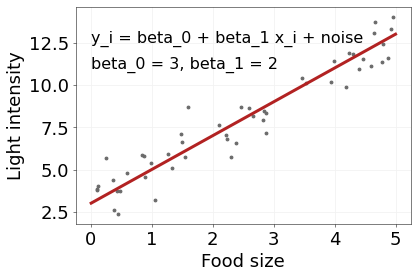

In [6]:
def generating_function(x_star, beta_0_star, beta_1_star):
    y = beta_1_star * x_star + beta_0_star
    return y

fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range, generating_function(x_range, beta_0_star=3, beta_1_star=2),
        c="#B22222", linewidth=3, zorder=9)

# Noisy samples
ax.scatter(x_star[:50], y[:50],
        c="#696969", s=8, zorder=8)

ax.text(0, 12.5, "y_i = beta_0 + beta_1 x_i + noise", fontsize=16)
ax.text(0, 11, "beta_0 = 3, beta_1 = 2", fontsize=16)

# Axis labels and styling
ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=18,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Now we can define the agent.

In [7]:
# Agent parameters
agent_params = {
    "std_y"  : 1,      # Likelihood standard deviation
    "x_range": x_range   # Support of x
}

# Learning with previously observed observations and known external states
agent = MaximumLinearRegressionAgent(params=agent_params)
agent.learn_parameters(x_star, y)

print(f"Estimate of beta_0 = {np.round(agent.beta_0)}")
print(f"Estimate of beta_1 = {np.round(agent.beta_1)}")

Estimate of beta_0 = 3.0
Estimate of beta_1 = 2.0


In [8]:
# Generate a new data point from the environment using a new external state
x_star_new = 2.2
env.build(x_star_new)
y = env.generate()

# Infer new state given data
agent.infer_state(y)

In [9]:
posterior_mode = x_range[np.argmax(agent.posterior)]
beta_0_estimate = np.round(agent.beta_0, 3)
beta_1_estimate = np.round(agent.beta_1, 3)

# Print out the results
print(f"True hidden state = {x_star_new}")
print(f"Estimate of hidden state = {posterior_mode}")
print(f"Estimate of beta_0 = {beta_0_estimate}")
print(f"Estimate of beta_1 = {beta_1_estimate}")

True hidden state = 2.2
Estimate of hidden state = 3.4499999999999997
Estimate of beta_0 = 3.091
Estimate of beta_1 = 1.971


In [24]:
def simulation(N, x_star_new, env_params, agent_params):
    """ Setup environment """
    env = create_environment(name="static_linear", params=env_params)

    # Generate data from the support of x
    x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
    x_star  = np.random.choice(x_range, size=N)          # N randomy external states
    y       = np.zeros(N)                                # Empty array for N data samples

    # Generate N samples
    for idx, x in enumerate(x_star):
        env.build(x)
        y[idx] = env.generate()
        
    # Learning with previously observed observations and known external states
    agent = MaximumLinearRegressionAgent(params=agent_params)
    agent.learn_parameters(x_star, y)
    
    # Generate a new data point from the environment using a new external state
    env.build(x_star_new)
    y_new = env.generate()

    # Infer new state given data
    agent.infer_state(y_new)
    
    return agent, env, x_star, y

In [25]:
# Simulation setup 
n_iterations = 100
x_star_new   = 2.2

# Initialize empty arrays to fill
posterior_mode  = np.zeros(n_iterations)
beta_0_estimate = np.zeros(n_iterations)
beta_1_estimate = np.zeros(n_iterations)

for i in range(n_iterations):
    agent, env, x_star, y = simulation(N, x_star_new, env_params, agent_params)
    posterior_mode[i]  = x_range[np.argmax(agent.posterior)]
    beta_0_estimate[i] = agent.beta_0
    beta_1_estimate[i] = agent.beta_1
    
error = x_star_new - posterior_mode

/tmp/ipykernel_526085/3818291856.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=axes[1])


<Figure size 432x288 with 0 Axes>

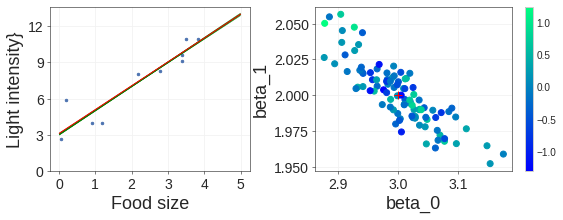

In [29]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(8,3.2), gridspec_kw={'width_ratios': [1.7, 2.1]})

"""" LEFT PLOT """
# Scatter plot of all x and y points generated
axes[0].scatter(x_star[:10], y[:10], s=6)

# Create possible lines with the first 10 beta_0 or beta_1 estimates
for beta_0, beta_1 in zip(beta_0_estimate[:10], beta_1_estimate[:10]):
    axes[0].plot(x_range, generating_function(x_range, beta_0_star=beta_0, beta_1_star=beta_1),
        c="green",
        linewidth=0.5)

# True parameter line in red    
axes[0].plot(x_range, generating_function(x_range, beta_0_star=beta_0, beta_1_star=beta_1),
    c="red",
    linewidth=1)

""" RIGHT PLOT """
# Plot all beta_0 and beta_1 estimates and color according to the error in the hidden state estimate
im = axes[1].scatter(beta_0_estimate, beta_1_estimate, c=error, cmap="winter")
fig.colorbar(im, ax=axes[1])

axes[1].plot(3, 2, marker="+", color="red", markersize=8)

""" GLOBAL PLOT SETTINGS """
# Axis labels and styling
axes[0].set_xlabel("Food size", fontsize=18)
axes[0].set_ylabel("Light intensity}", fontsize=18)
axes[1].set_xlabel("beta_0", fontsize=18)
axes[1].set_ylabel("beta_1", fontsize=18)

# Axis ranges
axes[0].set_xticks(np.arange(0,6,1))
axes[0].set_yticks(np.arange(0,15,3))

# Apply to both plots
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        labelsize=14,
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

ax.set_axisbelow(True)
fig.tight_layout()